In [1]:
import os
import glob as glob
import timecorr as tc
import hypertools as hyp
import numpy as np
import pandas as pd
from scipy.io import loadmat
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
import timecorr as tc
from timecorr.helpers import isfc, wisfc, mean_combine, corrmean_combine


In [2]:
datadir = os.path.join(os.getenv('HOME'), 'Desktop', 'pca_env', 'pca_paper', 'pieman', 'data')


In [3]:
figdir = '../figs'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [4]:
#figdir = '/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/figs'

In [5]:
factors=700

In [6]:
if factors == 100:
    pieman_name = '../../data/pieman_ica100.mat'
else:
    pieman_name = '../../data/pieman_data.mat'

pieman_conds = ['intact', 'paragraph', 'word', 'rest']

In [7]:
pieman_data = loadmat(pieman_name)

In [8]:
debug = False

In [9]:
if debug:
    data = []
    conds = []
    for c in pieman_conds:
        next_data = list(map(lambda i: pieman_data[c][:, i][0][:30, :10], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

else:

    data = []
    conds = []
    for c in pieman_conds:
        if c == 'paragraph':
            if factors == 700:
                next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
            else:
                next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 0)[0]))
        else:
            next_data = list(map(lambda i: pieman_data[c][:, i][0], np.arange(pieman_data[c].shape[1])))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

In [10]:
data = np.array(data)
conds = np.array(conds)

In [ ]:
intact = hyp.describe(list(data[conds == 'intact']), reduce='PCA', show=False)
paragraph = hyp.describe(list(data[conds == 'paragraph']), reduce='PCA', show=False)
word = hyp.describe(list(data[conds == 'word']), reduce='PCA', show=False)
rest = hyp.describe(list(data[conds == 'rest']), reduce='PCA', show=False)

/usr/local/lib/python3.6/site-packages/hypertools/tools/describe.py:61: UserWarning: When input data is large, this computation can take a long time.
  warnings.warn('When input data is large, this computation can take a long time.')


In [ ]:
pca_pd = pd.DataFrame({'intact':intact['average'],'paragraph':paragraph['average'],'word':word['average'],'rest':rest['average']})


In [ ]:
pca_pd.head()

In [ ]:
pieman_conds

In [ ]:

max_dims = len(intact['average'])
colors=['r', 'y', 'g', 'b']
fig, ax = plt.subplots()
for i, c in enumerate(pieman_conds):
    print(i)
    sns.tsplot(data=pca_pd[c], time=[n for n in range(2, max_dims+2)], color=colors[i], err_style="unit_traces", ax=ax)
ax.set_title('Correlation with raw data by number of components')
ax.set_ylabel('Correlation')
ax.set_xlabel('Number of components')
ax.legend(loc='center right', bbox_to_anchor=(1.6, 0.75), ncol=1)
plt.axhline(y=.9, c='k',linestyle='dashed',zorder=-1)
plt.show()

## pieman pca decoding

In [17]:
resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100'

In [18]:
conds =glob.glob(os.path.join(resultsdir, '*.csv'))

In [19]:
conds

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100/intact.csv',
 '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100/paragraph.csv',
 '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100/rest.csv',
 '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100/word.csv']

In [20]:
full_data = pd.DataFrame()
for c in conds:
    data = pd.read_csv(c)
    data['condition'] = os.path.basename(os.path.splitext(c)[0])

    if full_data.empty:
        full_data = data
    else:
        full_data = full_data.append(data)

In [21]:
full_data

,Unnamed: 0,rank,accuracy,error,dims,folds,iteration,condition
0,0,0.763222,0.006667,0.458911,1,0,0,intact
1,0,0.705522,0.010000,0.333711,2,0,0,intact
2,0,0.773344,0.020000,0.321156,3,0,0,intact
3,0,0.765333,0.006667,0.315078,4,0,0,intact
4,0,0.852389,0.066667,0.230633,5,0,0,intact
5,0,0.877244,0.063333,0.203222,6,0,0,intact
6,0,0.895533,0.066667,0.192889,7,0,0,intact
7,0,0.933111,0.090000,0.149878,8,0,0,intact
8,0,0.937300,0.106667,0.133511,9,0,0,intact
9,0,0.937922,0.116667,0.142544,10,0,0,intact


In [22]:
full_data[full_data['condition']=='intact'].head()

,Unnamed: 0,rank,accuracy,error,dims,folds,iteration,condition
0,0,0.763222,0.006667,0.458911,1,0,0,intact
1,0,0.705522,0.010000,0.333711,2,0,0,intact
2,0,0.773344,0.020000,0.321156,3,0,0,intact
3,0,0.765333,0.006667,0.315078,4,0,0,intact
4,0,0.852389,0.066667,0.230633,5,0,0,intact


In [23]:
outfile = os.path.join(figdir, 'Accuracy_by_components.pdf')

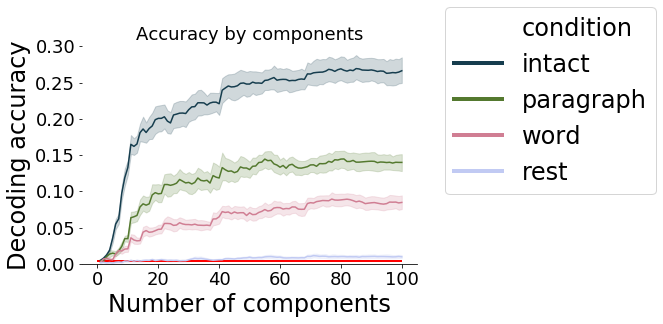

In [25]:
fig, ax = plt.subplots()
sns.lineplot(x="dims", y="accuracy",
             hue="condition",
             data=full_data, ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
sns.despine(ax=ax, left=True)
ax.set_title('Accuracy by components')
ax.set_ylabel('Decoding accuracy',fontsize=24)
ax.set_xlabel('Number of components',fontsize=24)
ax.set_ylim(0, .3)
ax.hlines(y=1/300, xmin=0, xmax=100, linewidth=2, color='r')
#ax.legend(loc='center right', bbox_to_anchor=(1.6, 0.75), ncol=1)
l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
for line in l.get_lines():
    line.set_linewidth(4.0)
fig.savefig(outfile, bbox_inches='tight')

In [26]:
resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_chunked/PCA/ndims_100'

In [27]:
conds =glob.glob(os.path.join(resultsdir, '*.csv'))

In [28]:
full_data = pd.DataFrame()
for c in conds:
    data = pd.read_csv(c)
    data['condition'] = os.path.basename(os.path.splitext(c)[0])

    if full_data.empty:
        full_data = data
    else:
        full_data = full_data.append(data)

In [29]:
full_data[full_data['condition']=='intact'].head()

,Unnamed: 0,rank,accuracy,error,dims,folds,iteration,third,condition
0,0,0.835978,0.010000,0.486389,1,0,1,0,intact
1,0,0.755456,0.010000,0.345556,2,0,1,0,intact
2,0,0.777344,0.016667,0.288767,3,0,1,0,intact
3,0,0.853167,0.093333,0.230400,4,0,1,0,intact
4,0,0.896922,0.100000,0.229467,5,0,1,0,intact


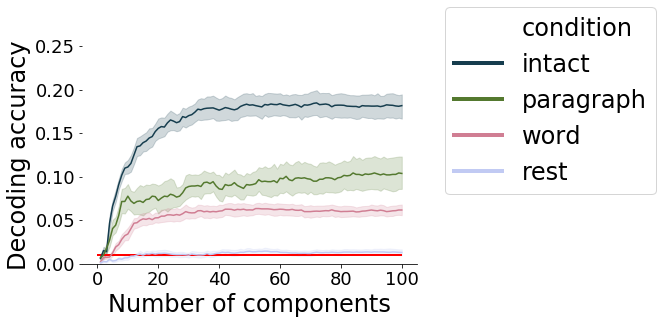

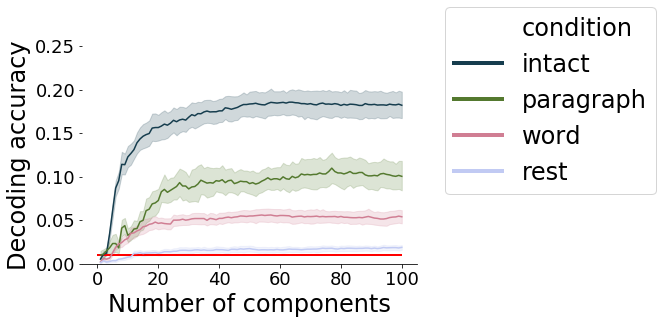

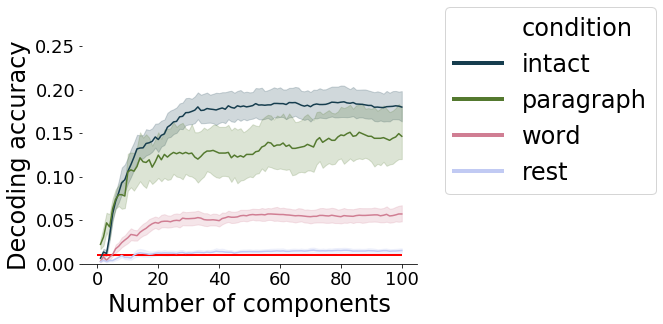

In [30]:
for i in range(3):
    outfile = os.path.join(figdir, 'Accuracy_by_components_third_' + str(i) + '.pdf')
    fig, ax = plt.subplots()
    sns.lineplot(x="dims", y="accuracy",
                 hue="condition",
                 data=full_data[full_data['third']==i], ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
    sns.despine(ax=ax, left=True)
    #ax.set_title('Accuracy by components for third: ' + str(i + 1))
    ax.set_ylabel('Decoding accuracy',fontsize=24)
    ax.set_xlabel('Number of components',fontsize=24)
    ax.set_ylim(0, .25)
    ax.hlines(y=1/100, xmin=0, xmax=100, linewidth=2, color='r')
    l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
    for line in l.get_lines():
        line.set_linewidth(4.0)
    fig.savefig(outfile, bbox_inches='tight')